In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ============================================================
# Utilities
# ============================================================

Nx = Ny = 32


def gaussian_forcing_2d(X, Y, mux, muy, sigx, sigy, amp=1.0):
    return amp * np.exp(
        -((X - mux)**2 / (2*sigx**2) + (Y - muy)**2 / (2*sigy**2))
    )


def compute_2d_poisson(x, y, f, bc):
    Nx = len(x)
    Ny = len(y)

    if Nx < 3 or Ny < 3:
        raise ValueError(f"Invalid grid: Nx={Nx}, Ny={Ny}")

    hx = x[1] - x[0]
    hy = y[1] - y[0]

    Ix = np.eye(Nx-2)
    Iy = np.eye(Ny-2)

    Dx = 2*np.eye(Nx-2) - np.diag(np.ones(Nx-3),1) - np.diag(np.ones(Nx-3),-1)
    Dy = 2*np.eye(Ny-2) - np.diag(np.ones(Ny-3),1) - np.diag(np.ones(Ny-3),-1)

    L = np.kron(Iy, Dx)/hx**2 + np.kron(Dy, Ix)/hy**2

    b = f[1:-1,1:-1].copy()
    b[0,:]  += bc["left"][1:-1]/hx**2
    b[-1,:] += bc["right"][1:-1]/hx**2
    b[:,0]  += bc["bottom"][1:-1]/hy**2
    b[:,-1] += bc["top"][1:-1]/hy**2

    u_inner = np.linalg.solve(L, b.reshape(-1))

    u = np.zeros((Nx,Ny))
    u[1:-1,1:-1] = u_inner.reshape(Nx-2,Ny-2)
    u[0,:]  = bc["left"]
    u[-1,:] = bc["right"]
    u[:,0]  = bc["bottom"]
    u[:,-1] = bc["top"]

    return u



def boundary_loss(u, bc):
    return (
        ((u[:,0,:]  - bc["left"])**2).mean() +
        ((u[:,-1,:] - bc["right"])**2).mean() +
        ((u[:,:,0]  - bc["bottom"])**2).mean() +
        ((u[:,:,-1] - bc["top"])**2).mean()
    )


def bc_features(bc):
    # Return full BC profiles instead of just means
    # Shape: (B, 2*Nx + 2*Ny) for all boundary values
    return torch.cat([
        bc["left"],    # (B, Ny)
        bc["right"],   # (B, Ny)
        bc["bottom"],  # (B, Nx)
        bc["top"],     # (B, Nx)
    ], dim=1)

# ============================================================
# DeepONet
# ============================================================

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=(256,256)):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d,h), nn.Tanh()]
            d = h
        layers.append(nn.Linear(d,out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)


class DeepONet2D(nn.Module):
    def __init__(self, branch_dim, p=256):
        super().__init__()
        self.branch = MLP(branch_dim,p)
        self.trunk  = MLP(2,p)
        self.bias   = nn.Parameter(torch.zeros(1))

    def forward(self, branch_input, coords):
        b = self.branch(branch_input)        # (B,p)
        t = self.trunk(coords)               # (N,p)
        return (b[:,None,:]*t[None,:,:]).sum(-1) + self.bias


# ============================================================
# Trainer
# ============================================================

class Trainer:
    def __init__(self, model, coords, f, u, bc,
                 lr=1e-3, res_w=1.0, bc_w=50.0, device="cpu"):
        self.model = model.to(device)
        self.coords = coords.to(device).requires_grad_(True)
        self.f = torch.tensor(f, dtype=torch.float32, device=device)
        self.u = torch.tensor(u, dtype=torch.float32, device=device)
        self.bc = {k: torch.tensor(v, dtype=torch.float32, device=device)
                   for k,v in bc.items()}
        self.opt = torch.optim.Adam(model.parameters(), lr=lr)
        self.res_w = res_w
        self.bc_w  = bc_w
        self.B = f.shape[0]
        self.device = device

    def laplacian(self, u):
        g = torch.autograd.grad(u, self.coords,
                                torch.ones_like(u), create_graph=True)[0]
        ux, uy = g[:,0], g[:,1]
        uxx = torch.autograd.grad(ux, self.coords,
                                  torch.ones_like(ux), create_graph=True)[0][:,0]
        uyy = torch.autograd.grad(uy, self.coords,
                                  torch.ones_like(uy), create_graph=True)[0][:,1]
        return uxx + uyy

    def train(self, epochs=200):
        for ep in range(1,epochs+1):
            self.opt.zero_grad()

            branch = torch.cat([self.f, bc_features(self.bc)], dim=1)
            up = self.model(branch, self.coords)
            data_loss = ((up - self.u)**2).mean()

            res = 0.0
            for i in range(self.B):
                r = -self.laplacian(up[i]) - self.f[i]
                res += (r**2).mean()
            res /= self.B

            bc_l = boundary_loss(up.view(self.B,Nx,Ny), self.bc)
            loss = data_loss + self.res_w*res + self.bc_w*bc_l

            loss.backward()
            self.opt.step()

            if ep % 20 == 0 or ep == 1:
                print(f"Ep {ep:4d} | "
                      f"L {loss.item():.3e} | "
                      f"D {data_loss.item():.2e} | "
                      f"R {res.item():.2e} | "
                      f"BC {bc_l.item():.2e}")

# ============================================================
# Main
# ============================================================

np.random.seed(0)
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

Nx = Ny = 32
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
X,Y = np.meshgrid(x,y,indexing="ij")
coords = torch.tensor(np.c_[X.ravel(),Y.ravel()], dtype=torch.float32)

N = 50
f_all, u_all = [], []
bc_all = {"left":[], "right":[], "bottom":[], "top":[]}

for _ in range(N):
    f = gaussian_forcing_2d(X,Y,
        *np.random.uniform(0.2,0.8,2),
        *np.random.uniform(0.05,0.15,2))
    f /= np.max(np.abs(f))
    bc = {
        "left":   np.random.uniform(-1,1,Ny),
        "right":  np.random.uniform(-1,1,Ny),
        "bottom": np.random.uniform(-1,1,Nx),
        "top":    np.random.uniform(-1,1,Nx),
    }
    u = compute_2d_poisson(x,y,f,bc)
    f_all.append(f.ravel())
    u_all.append(u.ravel())
    for k in bc: bc_all[k].append(bc[k])

f_all = np.array(f_all)
# Normalize solutions
u_scale = np.max(np.abs(u_all))
u_all /= u_scale

# ALSO normalize BCs by the same scale for consistency
for k in bc_all:
    bc_all[k] = np.array(bc_all[k]) / u_scale
                #   lr=1e-3, res_w=1.0, bc_w=50.0, device=device)
# Update model: branch_dim = Nx*Ny (forcing) + 2*Nx + 2*Ny (full BC profiles)
model = DeepONet2D(branch_dim=Nx*Ny + 2*Nx + 2*Ny, p=256)
trainer = Trainer(model, coords, f_all, u_all, bc_all,
                  lr=1e-3, res_w=1.0, bc_w=50.0, device=device)
trainer.train(epochs=200)

# ============================================================
# Test: Generate multiple samples and plot 1D slices
# ============================================================

np.random.seed(42)  # Different seed for test samples
n_test_samples = 3  # Number of test samples to visualize
sample_indices = [1, 2, 3]  # Sample labels (just for display)

# Generate test data
test_data = []
for i in range(n_test_samples):
    f_test = gaussian_forcing_2d(X, Y,
        *np.random.uniform(0.2, 0.8, 2),
        *np.random.uniform(0.05, 0.15, 2))
    f_test /= np.max(np.abs(f_test))
    
    # Generate random boundary conditions for this test sample
    bc_test = {
        "left":   np.random.uniform(-1, 1, Ny),
        "right":  np.random.uniform(-1, 1, Ny),
        "bottom": np.random.uniform(-1, 1, Nx),
        "top":    np.random.uniform(-1, 1, Nx),
    }
    
    # Compute ground truth with unnormalized BCs
    u_true = compute_2d_poisson(x, y, f_test, bc_test)
    
    # Normalize BCs for model input (consistent with training)
    bc_test_norm = {k: v / u_scale for k, v in bc_test.items()}
    
    with torch.no_grad():
        f_flat = torch.tensor(f_test.ravel()[None,:], dtype=torch.float32, device=device)
        # Use full BC profiles instead of means
        bc_flat = torch.tensor(np.concatenate([
            bc_test_norm["left"],
            bc_test_norm["right"],
            bc_test_norm["bottom"],
            bc_test_norm["top"]
        ])[None,:], dtype=torch.float32, device=device)
        u_pred = model(torch.cat([f_flat, bc_flat], 1), coords.to(device))
        u_pred = u_pred.cpu().numpy().reshape(Nx, Ny) * u_scale
    
    test_data.append((u_true, u_pred))


Ep    1 | L 6.926e+01 | D 6.68e-02 | R 3.07e-02 | BC 1.38e+00
Ep   20 | L 6.647e+01 | D 5.57e-02 | R 3.45e-02 | BC 1.33e+00
Ep   40 | L 6.535e+01 | D 5.05e-02 | R 3.52e-02 | BC 1.31e+00
Ep   60 | L 6.518e+01 | D 4.99e-02 | R 3.19e-02 | BC 1.30e+00
Ep   80 | L 6.507e+01 | D 4.96e-02 | R 3.11e-02 | BC 1.30e+00
Ep  100 | L 6.493e+01 | D 4.94e-02 | R 3.19e-02 | BC 1.30e+00
Ep  120 | L 6.480e+01 | D 4.91e-02 | R 3.55e-02 | BC 1.29e+00
Ep  140 | L 6.468e+01 | D 4.89e-02 | R 4.02e-02 | BC 1.29e+00
Ep  160 | L 6.456e+01 | D 4.86e-02 | R 4.41e-02 | BC 1.29e+00
Ep  180 | L 6.442e+01 | D 4.83e-02 | R 4.96e-02 | BC 1.29e+00
Ep  200 | L 6.526e+01 | D 5.12e-02 | R 4.67e-02 | BC 1.30e+00


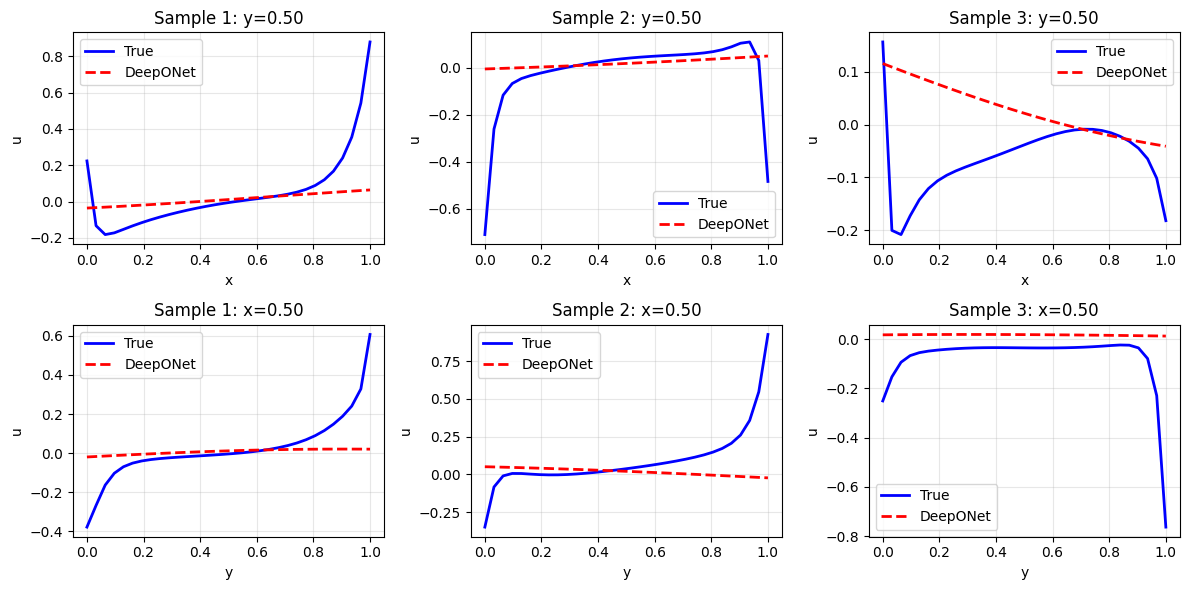

In [8]:
# Plot 1D slices: Top row = y=0.5 slice, Bottom row = x=0.5 slice
slice_idx = Nx // 2  # Index for x=0.5 or y=0.5

fig, axes = plt.subplots(2, n_test_samples, figsize=(4*n_test_samples, 6))

for col, (u_true, u_pred) in enumerate(test_data):
    # Top row: slice along x at y=0.5 (fixed y, varying x)
    ax = axes[0, col]
    ax.plot(x, u_true[:, slice_idx], 'b-', linewidth=2, label='True')
    ax.plot(x, u_pred[:, slice_idx], 'r--', linewidth=2, label='DeepONet')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(f'Sample {sample_indices[col]}: y=0.50')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Bottom row: slice along y at x=0.5 (fixed x, varying y)
    ax = axes[1, col]
    ax.plot(y, u_true[slice_idx, :], 'b-', linewidth=2, label='True')
    ax.plot(y, u_pred[slice_idx, :], 'r--', linewidth=2, label='DeepONet')
    ax.set_xlabel('y')
    ax.set_ylabel('u')
    ax.set_title(f'Sample {sample_indices[col]}: x=0.50')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()